### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### Переходим к практике

In [12]:
import pandas as pd

Наши новости

In [13]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [14]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [15]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [16]:
!conda env list

# conda environments:
#
base                  *  D:\Install\Anaconda3
Scrapy                   D:\Install\Anaconda3\envs\Scrapy
Selenium                 D:\Install\Anaconda3\envs\Selenium
algoritms_in_bis         D:\Install\Anaconda3\envs\algoritms_in_bis
pcr_env                  D:\Install\Anaconda3\envs\pcr_env



In [17]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Андрей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [19]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [20]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [21]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

D:\Install\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 25.1 s


In [22]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 50s


А теперь в 3 строчки обучим нашу модель

In [23]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [24]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [25]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 32.4 s


In [26]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [27]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.13673359),
 (4, 0.36015663),
 (17, 0.029071234),
 (19, 0.14972748),
 (24, 0.30647746)]

In [28]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: миссия грузия казахстан грузинский мораторий киргизия таджикистан
topic_1: пенсия пациент кожа общество рт выражение реальный
topic_2: исследование напомнить китай nn женщина писать сша
topic_3: взрыв конкурс выяснить супруг лётчик помещение дональд
topic_4: рак участок торговый хороший эксперимент программа пройти
topic_5: год млн рост тыс это составить компания
topic_6: год который суд дело это смерть также
topic_7: вода поверхность система восток египет министерство океан
topic_8: реформа культура министерство фонд регион искусство развивающийся
topic_9: погибнуть палата дональд бомба турецкий регистрация образовать
topic_10: это который россия глава совет президент свой
topic_11: обнаружить полиция задержать год сотрудник иск человек
topic_12: эволюция австралийский ким кремль профессия корея предсказать
topic_13: станция турция британский офицер граница рекомендовать улица
topic_14: вероятно умереть страдать сенатор девочка родственник спустя
topic_15: год это который рос

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [29]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [30]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.098552,0.0,0.0,0.0,0.0,...,0.418967,0.0,0.000000,0.0,0.026332,0.0,0.0,0.0,0.011111,0.000000
1,4896,0.0,0.0,0.000000,0.460725,0.380034,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.0,0.000000,0.136581,0.359657,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.029066,0.0,0.149105,0.0,0.0,0.0,0.000000,0.307756
3,4898,0.0,0.0,0.000000,0.000000,0.165281,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.823849
4,4899,0.0,0.0,0.388085,0.070852,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [31]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [32]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [146]:
doc_copy = doc_dict[293622].copy()

In [149]:
doc_copy*3

array([0.        , 0.        , 0.21403585, 0.        , 0.08778768,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.44500431,
       0.32065324, 0.        , 0.16498687, 0.        , 0.10620492,
       0.        , 0.18435394, 0.40400152, 0.74275196, 0.30290479])

In [34]:
users['liststring'] = [' '.join(map(str, eval(l))) for l in users['articles']]

In [212]:
users['liststring']

0       293672 293328 293001 293622 293126 1852
1               3405 1739 2972 1158 1599 322665
2               1845 2009 2356 1424 2939 323389
3               5933 6186 5055 6977 5206 488389
4                707 1144 2532 2928 3133 324592
                         ...                   
7995     323918 323362 323704 323452 324291 251
7996            5532 5860 7755 7140 5182 488337
7997    322811 323898 321858 323345 323491 2193
7998            5436 6092 6891 7045 5320 487379
7999    294096 293759 294178 293544 293921 2909
Name: liststring, Length: 8000, dtype: object

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(users['liststring'])

In [195]:
X_tfidf[5, 6816]

0.4096314175049525

In [121]:
feature_names = vectorizer.get_feature_names()

In [211]:
len(feature_names)

14781

In [164]:
user = 0
a = [list(X_tfidf[user].nonzero()[1]) for user in range(users.shape[0])]

In [165]:
a

[[825, 2406, 2810, 2304, 2570, 2848],
 [5365, 576, 157, 4300, 714, 7624],
 [6094, 3031, 411, 1288, 969, 818],
 [10260, 11415, 13586, 10616, 12750, 12480],
 [7307, 4453, 2138, 1455, 144, 13688],
 [530, 6816, 5127, 6980, 6132, 6577],
 [7750, 3071, 3733, 3973, 3510, 2414],
 [10894, 14301, 14285, 13548, 10571, 13534],
 [8371, 7041, 4818, 5694, 7415, 5540],
 [9705, 12905, 13777, 14031, 12997, 14498],
 [8498, 14037, 5625, 5677, 4845, 5365],
 [10753, 10848, 14128, 13266, 14166, 12727],
 [8904, 6926, 6000, 5041, 5483, 5744],
 [7559, 3288, 1899, 3721, 2509, 2800],
 [8865, 7818, 6327, 5357, 6923, 7358],
 [7306, 950, 14686, 1618, 14659, 790],
 [8874, 6920, 4602, 5156, 7189, 7273],
 [10255, 13053, 10537, 13118, 12235, 13073],
 [8715, 5823, 5463, 6460, 6670, 7528],
 [8219, 5212, 4746, 4902, 4540, 6514],
 [4834, 135, 4380, 4398, 737, 7679],
 [5685, 317, 7574, 4299, 12918, 657],
 [847, 6029, 6818, 5982, 6453, 7075],
 [665, 7319, 5161, 6218, 4688, 6073],
 [757, 4174, 2227, 2910, 2854, 3510],
 [1728, 4

In [130]:
users_weights = np.zeros(users.)
user = 1
feature_index = X_tfidf[user,:].nonzero()[1]
tfidf_scores = zip(feature_index, [X_tfidf[user, x] for x in feature_index])

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

322665 0.36877650165690723
1599 0.42078386231542764
1158 0.3879708710712454
2972 0.4399782317297658
1739 0.42078386231542764
3405 0.40716524048558356


In [198]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, processing_factor='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if processing_factor == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif processing_factor == 'median':
        user_vector = np.median(user_vector, 0)
    elif processing_factor == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        raise AttributeError("Указан не поддерживаемый фактор обработки.")    
    return user_vector

def get_user_embedding_tfidf(user, user_articles_list, processing_factor='mean'):
    vectorizer = TfidfVectorizer()
    users['liststring'] = [' '.join(map(str, eval(l))) for l in users['articles']]
    tfidf_matrix = vectorizer.fit_transform(users['liststring'])
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] * tfidf_matrix[user, doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [142]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.02702641, 0.        , 0.00532277,
       0.05212504, 0.13033902, 0.00316988, 0.        , 0.00858202,
       0.15485618, 0.01254253, 0.00362742, 0.        , 0.00641862,
       0.16387242, 0.        , 0.01479719, 0.        , 0.09080368,
       0.08678186, 0.06153782, 0.12808465, 0.0212437 , 0.01645543])

In [150]:
user_articles_list = eval(user_articles_list)
user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])

In [166]:
user_articles_list

[323329, 321961, 324743, 323186, 324632, 474690]

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [39]:
#users['articles'].iloc[33]

In [40]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [41]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.014774,0.004910,0.045296,0.124818,0.078727,0.002309,0.003864,...,0.062775,0.000000,0.048920,0.0,0.066642,0.049438,0.010242,0.137992,0.086245,0.050468
1,u108690,0.0,0.0,0.043606,0.004089,0.004690,0.048250,0.097017,0.029431,0.000000,...,0.121441,0.000000,0.047335,0.0,0.192197,0.040723,0.016056,0.145856,0.023457,0.019993
2,u108339,0.0,0.0,0.008346,0.000000,0.007848,0.021408,0.151227,0.007475,0.000000,...,0.093284,0.004575,0.028706,0.0,0.069801,0.053838,0.000000,0.180683,0.091541,0.038970


In [213]:
# lst = []
# for user, user_articles_list in enumerate(users['articles']):
#     lst.append(get_user_embedding_tfidf(user, user_articles_list))
# user_embeddings = pd.DataFrame(lst)
# # user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_tfdif(x, y), 1)])
# user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
# user_embeddings['uid'] = users['uid'].values
# user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
# user_embeddings.head(3)

In [189]:
for x, y in zip(users['articles'], users['uid']):
    print(x, y)

[293672, 293328, 293001, 293622, 293126, 1852] u105138
[3405, 1739, 2972, 1158, 1599, 322665] u108690
[1845, 2009, 2356, 1424, 2939, 323389] u108339
[5933, 6186, 5055, 6977, 5206, 488389] u101138
[707, 1144, 2532, 2928, 3133, 324592] u108248
[323868, 323426, 324267, 322426, 324104, 1550] u106662
[293138, 294471, 295012, 294736, 293949, 3544] u105949
[6928, 5009, 6940, 7629, 7644, 512736] u102457
[322838, 324699, 322991, 322120, 324327, 472331] u104124
[7827, 6427, 7394, 7151, 6335, 487254] u101386
[322147, 322974, 322922, 74, 322665, 472624] u104519
[6163, 7517, 6678, 7482, 5124, 511479] u101068
[323041, 322782, 322341, 323296, 324213, 473474] u103480
[293610, 293254, 294722, 290157, 294206, 3333] u105962
[324642, 324210, 322657, 323620, 43, 473393] u104980
[1815, 881, 2707, 908, 1991, 324591] u108233
[324558, 324474, 322456, 321907, 324207, 473417] u103997
[6496, 5702, 6539, 4975, 6478, 488381] u101343
[33, 323960, 323752, 322762, 323119, 473084] u104440
[323805, 321846, 322203, 32204

[295066, 294547, 294915, 293112, 293414, 2557] u105874
[1044, 3216, 2143, 2480, 3272, 322377] u108924
[7101, 5430, 6142, 4898, 6630, 487912] u101175
[5700, 6003, 7512, 5684, 5379, 488371] u102729
[5149, 5813, 7134, 7490, 4929, 487118] u102827
[7032, 5367, 6538, 5173, 6198, 513422] u102242
[5443, 7188, 4982, 6779, 6971, 487661] u102522
[292781, 295030, 292808, 293455, 295309, 2487] u105478
[324410, 322586, 323363, 323274, 324500, 2149] u106233
[2853, 1223, 1367, 1864, 1950, 322816] u108829
[324521, 322222, 324357, 324682, 322922, 473136] u104428
[3121, 1315, 2220, 2896, 579, 322371] u108346
[322970, 322467, 323436, 322933, 323455, 474399] u107886
[4921, 6097, 5403, 7293, 7454, 511578] u102823
[323731, 321927, 324158, 323744, 322647, 511391] u103653
[321978, 322047, 323199, 322604, 324117, 473081] u104623
[322507, 323303, 322515, 324357, 324604, 530845] u104011
[323630, 324454, 322447, 322773, 322335, 474037] u104116
[322026, 324551, 322408, 323302, 322935, 474701] u107480
[322181, 32360

[3201, 1000, 3088, 2652, 1770, 321973] u108783
[294920, 294724, 294354, 295373, 294204, 2006] u105759
[293508, 294856, 290071, 292990, 293946, 3309] u105753
[322359, 322589, 323457, 323415, 324439, 1160] u106424
[323946, 323417, 322403, 322988, 324116, 473583] u104779
[324420, 324101, 322500, 323145, 324304, 1656] u106105
[322037, 322376, 323009, 323927, 323297, 473097] u103566
[7540, 5277, 5921, 7881, 6488, 487124] u102689
[6372, 6408, 7202, 6637, 7778, 487357] u101047
[295345, 295256, 292906, 293834, 294748, 3358] u105317
[322999, 324280, 324349, 323046, 324401, 473013] u104583
[323056, 322177, 322623, 324612, 322936, 533413] u104975
[321893, 324056, 322240, 323804, 323298, 3348] u106741
[323073, 323390, 322739, 324378, 322761, 471922] u107297
[322097, 323072, 324316, 321987, 322618, 472700] u104586
[1199, 749, 3044, 1741, 1349, 324613] u108289
[323937, 322192, 321930, 322298, 324657, 474080] u103206
[322158, 323226, 324521, 323732, 323734, 2728] u106615
[322561, 323840, 323491, 3219

[323671, 324636, 321851, 77, 323935, 519873] u104951
[1292, 1456, 1057, 1247, 981, 322336] u108785
[322385, 323644, 324746, 322379, 323492, 3410] u106586
[323851, 322689, 322999, 324670, 322514, 517515] u104105
[2626, 3267, 3442, 1688, 3431, 322941] u108077
[7359, 6430, 5002, 6423, 7018, 495398] u101411
[321871, 322214, 322557, 324300, 323123, 472517] u103433
[324495, 322205, 323569, 324291, 324514, 470522] u107934
[323562, 322586, 323280, 323760, 322053, 471253] u107058
[322859, 322260, 101, 322718, 322038, 471599] u107740
[7348, 6045, 7597, 6443, 6632, 495419] u102305
[322522, 324516, 322994, 322104, 323119, 473656] u103735
[322357, 322647, 324050, 324209, 322177, 1957] u106428
[6163, 6844, 5759, 6372, 5065, 487112] u101852
[323513, 323875, 323244, 322123, 323450, 471161] u107175
[6952, 6941, 5856, 7148, 5225, 488432] u101723
[295201, 295050, 295040, 293248, 294156, 2680] u105350
[324577, 322996, 323089, 323688, 323450, 474971] u107600
[323904, 324462, 324208, 323121, 323632, 460] u1

[5862, 5844, 6652, 7596, 5337, 512864] u102402
[322462, 324654, 324425, 323142, 322603, 473261] u104033
[324129, 324444, 101, 322777, 324003, 474174] u104766
[6222, 5961, 5922, 5056, 5472, 511308] u102118
[2100, 1733, 1988, 2584, 2206, 324760] u108488
[294454, 294744, 293382, 294557, 294741, 1739] u105809
[3087, 1808, 2319, 1032, 2584, 322596] u108181
[5842, 5630, 5331, 6571, 7227, 511565] u102988
[324685, 323025, 323532, 323107, 324268, 531928] u104197
[322272, 324299, 323045, 322835, 324195, 523021] u103146
[5293, 5988, 7368, 5609, 5820, 512760] u102779
[323244, 322878, 324111, 324684, 321879, 470535] u107857
[292883, 295053, 293339, 292871, 294162, 1805] u105142
[5296, 7622, 7240, 5840, 7548, 488181] u102366
[324135, 322824, 322037, 322411, 322537, 473579] u103368
[324126, 322245, 321852, 322756, 322836, 472831] u103800
[7198, 7363, 7105, 6584, 5324, 495444] u102794
[6246, 7413, 7673, 5750, 6858, 487704] u102725
[293932, 294014, 293576, 294992, 293415, 3385] u105764
[999, 1172, 1120

[6280, 6332, 5362, 6933, 6779, 513083] u102970
[5049, 7816, 6141, 5532, 5291, 486990] u102939
[295343, 293919, 293259, 295336, 292958, 778] u105267
[1265, 2697, 2028, 2594, 2588, 324211] u108498
[324495, 323000, 322137, 321926, 323647, 473182] u104114
[323268, 324639, 323801, 324364, 322108, 472873] u103625
[322011, 323697, 324752, 322311, 322145, 235] u107676
[14, 294534, 295074, 293620, 292702, 2270] u105829
[322906, 322381, 323965, 324466, 324621, 474118] u103442
[294161, 294834, 293753, 295224, 293051, 2053] u105065
[322698, 323335, 322654, 322998, 322349, 1280] u106510
[323165, 322185, 323381, 324201, 323499, 613] u106766
[1068, 3554, 2712, 2848, 2423, 322962] u108036
[292649, 294454, 293045, 294177, 293482, 2265] u105813
[290200, 295165, 295037, 294691, 294137, 3302] u105168
[324667, 322986, 323133, 322386, 324719, 3281] u106682
[6139, 6270, 5608, 7076, 7391, 488287] u101026
[323858, 324279, 323062, 322449, 322839, 470394] u107152
[293658, 294360, 294831, 293584, 293036, 3363] u1

[324216, 324235, 105, 323192, 322842, 472930] u103301
[5909, 7804, 5745, 7825, 6879, 561] u101937
[7534, 7083, 5640, 7510, 6037, 488013] u101610
[324582, 324261, 324681, 324558, 322114, 513674] u103365
[323177, 323686, 322085, 322307, 323777, 473535] u103611
[324435, 323019, 322170, 323177, 322270, 1597] u106962
[294751, 290072, 293265, 294382, 293490, 2607] u105485
[321858, 323857, 324389, 323287, 323482, 2763] u106972
[323304, 323932, 324503, 324682, 323788, 466] u107548
[324205, 321879, 322686, 324567, 94, 473005] u103140
[293478, 294126, 294554, 292990, 294645, 1617] u105128
[7123, 6355, 5200, 6617, 5374, 495508] u102879
[3090, 579, 1543, 733, 1816, 322131] u108904
[7115, 7841, 6626, 6721, 6503, 488354] u102032
[322566, 322570, 323296, 322137, 323253, 474978] u107454
[323040, 324389, 323911, 322290, 323984, 473371] u104395
[295338, 294637, 293147, 292666, 294828, 2334] u105815
[3052, 3528, 1659, 2373, 1764, 322454] u108812
[323875, 322155, 322238, 85, 322274, 471420] u107478
[6887,

[5405, 5551, 7867, 5979, 5545, 486908] u101634
[322580, 323125, 324237, 324682, 323677, 3156] u106277
[323463, 324339, 322866, 323837, 324486, 473330] u103719
[323888, 323213, 323243, 323839, 324591, 471579] u107520
[321896, 324758, 324663, 322802, 324051, 472754] u104198
[7484, 7157, 5601, 5938, 7421, 511299] u101256
[293024, 295221, 293827, 20, 294476, 1571] u105655
[322413, 82, 323907, 322350, 322683, 472937] u104914
[6106, 7359, 5648, 5980, 6184, 495364] u102209
[322457, 324389, 322804, 322225, 322872, 3180] u106552
[324570, 322759, 321907, 323621, 323201, 472356] u103924
[293619, 293320, 293981, 293774, 293316, 1207] u105364
[6637, 5363, 5464, 7402, 5270, 488438] u102869
[292743, 295185, 294948, 293667, 293895, 1580] u105431
[79, 323560, 323039, 323021, 324239, 532666] u104476
[323234, 322107, 322910, 324037, 322336, 513641] u103287
[5555, 5179, 5762, 6719, 7887, 487814] u102213
[322842, 323264, 54, 324678, 322583, 2350] u106320
[5116, 6795, 6651, 6151, 6748, 487911] u102440
[3233

In [183]:
for x in users[['articles', 'uid']]:
    print(x)

articles
uid


In [42]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [43]:
def get_embeddings(processing_factor='mean'):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, processing_factor), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    user_embeddings = pd.merge(user_embeddings, target, 'left')
    return user_embeddings

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.014774,0.004910,0.045296,0.124818,0.078727,0.002309,0.003864,...,0.000000,0.048920,0.0,0.066642,0.049438,0.010242,0.137992,0.086245,0.050468,0
1,u108690,0.0,0.0,0.043606,0.004089,0.004690,0.048250,0.097017,0.029431,0.000000,...,0.000000,0.047335,0.0,0.192197,0.040723,0.016056,0.145856,0.023457,0.019993,1
2,u108339,0.0,0.0,0.008346,0.000000,0.007848,0.021408,0.151227,0.007475,0.000000,...,0.004575,0.028706,0.0,0.069801,0.053838,0.000000,0.180683,0.091541,0.038970,1


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
users.head()

,uid,articles,liststring
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]",293672 293328 293001 293622 293126 1852
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]",3405 1739 2972 1158 1599 322665
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]",1845 2009 2356 1424 2939 323389
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]",5933 6186 5055 6977 5206 488389
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]",707 1144 2532 2928 3133 324592


In [71]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [95]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(users, target['churn'], random_state=0)

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column]
tfidf_pipeline = make_pipeline(FeatureExtractor(column='liststring'), TfidfVectorizer(), LogisticRegression())    

In [68]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('featureextractor', FeatureExtractor(column='liststring')),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [96]:
tfidf_pred = tfidf_pipeline.predict_proba(X_test)

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, tfidf_pred[:, 1])

In [112]:
n= 200
fscore = (2 * precision[:n] * recall[:n]) / (precision[:n] + recall[:n])

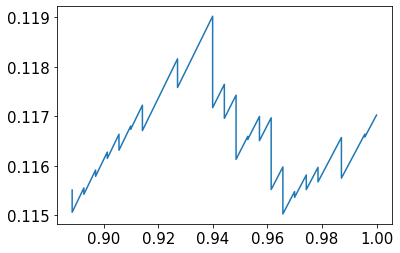

In [113]:
plt.plot(recall[:n], precision[:n])
plt.show()

D:\Install\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [97]:
new_row = ['TFIDF'] + list(get_info(y_test, tfidf_pred[:, 1]))
new_row = pd.Series(new_row, index=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
results = pd.concat([results, new_row.to_frame().T], ignore_index=True)

D:\Install\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [73]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22291693, 0.06625956, 0.6343139 , 0.23253028, 0.00724426,
       0.11179421, 0.06187479, 0.01324613, 0.14217154, 0.19766611])

In [74]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [75]:
def get_preds(X, model):
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return X_train, X_test, y_train, y_test, preds

In [76]:
def get_info(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)    
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)

In [77]:
results = pd.DataFrame(columns=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])

In [78]:
a = pd.Series(['asd',43, 5, 6, 8, 5], index=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
results = pd.concat([results, a.to_frame().T], ignore_index=True)

In [79]:
methods = ['mean', 'max', 'median']
results = pd.DataFrame(columns=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
for method in methods:
    X = get_embeddings(processing_factor=method)
    X_train, X_test, y_train, y_test, preds = get_preds(X, logreg)
    new_row = [method] + list(get_info(y_test, preds))
    new_row = pd.Series(new_row, index=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
    results = pd.concat([results, new_row.to_frame().T], ignore_index=True)

In [98]:
results

,method,threshold,fscore,precision,recall,roc_auc_score
0,mean,0.294113,0.716190,0.671429,0.767347,0.955765
1,max,0.349251,0.771372,0.751938,0.791837,0.962984
2,median,0.322909,0.763209,0.733083,0.795918,0.971605
3,TFIDF,0.212823,NaN,0.000000,0.000000,0.518132
4,TFIDF,0.261939,NaN,0.000000,0.000000,0.514239


### Рассчитаем Precision, Recall, F_score

In [81]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.322909, F-Score=0.763, Precision=0.733, Recall=0.796


In [84]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1684   71]
 [  51  194]]


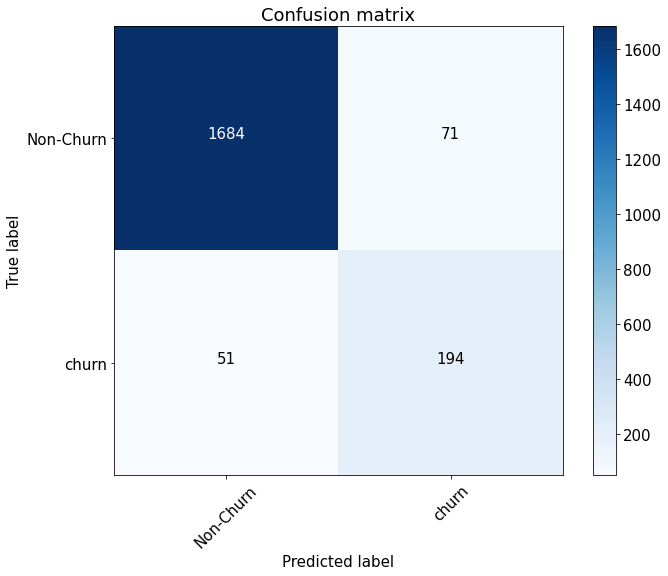

In [85]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [86]:
roc_auc_score(y_test, preds)

0.9716053258910402

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [215]:
def get_user_embedding(user_articles_list, processing_factor='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if processing_factor == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif processing_factor == 'median':
        user_vector = np.median(user_vector, 0)
    elif processing_factor == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        raise AttributeError("Указан не поддерживаемый фактор обработки.")    
    return user_vector

In [216]:
def get_embeddings(processing_factor='mean'):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, processing_factor), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    user_embeddings = pd.merge(user_embeddings, target, 'left')
    return user_embeddings

In [217]:
def get_preds(X, model):
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return X_train, X_test, y_train, y_test, preds

In [218]:
def get_info(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)    
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)

In [219]:
methods = ['mean', 'max', 'median']
results = pd.DataFrame(columns=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
for method in methods:
    X = get_embeddings(processing_factor=method)
    X_train, X_test, y_train, y_test, preds = get_preds(X, logreg)
    new_row = [method] + list(get_info(y_test, preds))
    new_row = pd.Series(new_row, index=['method', 'threshold', 'fscore', 'precision', 'recall', 'roc_auc_score'])
    results = pd.concat([results, new_row.to_frame().T], ignore_index=True)

In [220]:
results

,method,threshold,fscore,precision,recall,roc_auc_score
0,mean,0.294113,0.716190,0.671429,0.767347,0.955765
1,max,0.349251,0.771372,0.751938,0.791837,0.962984
2,median,0.322909,0.763209,0.733083,0.795918,0.971605


При использовании максимального значения точность классификации была несколько вышеа, а следовательно и f-score. Однак, при использовании медианы ROC AUC score всё же выше, то есть при использовании различных пороговых значений точность классификации может оказаться выше при использовании медианы. 

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

In [ ]:
!pip install gensim
!pip install natasha
!pip install pymorphy2
!pip install nltk